In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import R2Score,PearsonCorrCoef

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle("/data/cong/connectome.pkl")
df.rename(columns={ df.columns[0]: "Subject" }, inplace = True)

label = pd.read_csv("data/cognition_scores.csv")
label.rename(columns={ label.columns[0]: "Subject" }, inplace = True)

demographics = pd.read_csv("data/demographic.csv")

df = df.merge(demographics[["Gender","Subject"]], how='left', on='Subject')

In [3]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        
        super(Net, self).__init__()
        
        self.negative_slope = 0.05
        self.kernel_size = 2
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size//self.kernel_size, hidden_size//(self.kernel_size)))        
        self.layers.append(nn.Linear(hidden_size//(self.kernel_size**2), 100))
        self.layers.append(nn.Linear(100, 1))
        
        self.__weights_init_normal("kaiming")
        
    def forward(self, x):
        
        for i in range(2):
            x  = self.layers[i](x)
            x = F.leaky_relu(x, self.negative_slope)
            x = F.max_pool1d(x, self.kernel_size)

        for i in range(2, len(self.layers)):
            x  = self.layers[i](x)
            x = F.leaky_relu(x, self.negative_slope)
            
        return x
    
    def __weights_init_normal(self,  init_type):
        """
            Kaiming initialization:

            normal distribution with var = 2/dh) or var = 2/(1+ alpha**2)dh
        """
        
        for i in range(len(self.layers)):
            layer = self.layers[i]

            if isinstance(self.layers[i], nn.Linear):
                if init_type == "kaiming":    
                    nn.init.kaiming_normal_(layer.weight, a = self.negative_slope, nonlinearity = "leaky_relu")
                    nn.init.constant_(layer.bias, 0)
                
                elif init_type == "normal":
                    nn.init.kaiming_normal_(layer.weight, nonlinearity = "relu")
                    nn.init.constant_(layer.bias, 0)
                    
                else:
                    raise 
            

def r2_loss(output, target):
    target_mean = torch.mean(target)
    
    ss_res = torch.sum((target - output) ** 2)
    ss_tot = torch.sum((target - target_mean) ** 2)
    
    r2 = 1 - ss_res/ss_tot
    return r2

In [4]:
X = df.iloc[:, 1:]

shuffle = np.random.permutation(len(X))
test_size = int(len(X) * 0.2)

test_idx = shuffle[:test_size]
train_idx = shuffle[test_size:]

x_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :-1].values
y_train, y_test = label.iloc[train_idx, 1], label.iloc[ test_idx, 1].values

shuffle_val = np.random.permutation(len(x_train))
val_size = int(len(x_train) * 0.2)

val_idx = shuffle_val[:val_size]
train_idx = shuffle_val[val_size:]

gender_train, gender_val, gender_test  = x_train.iloc[train_idx, -1].values, x_train.iloc[val_idx, -1].values, X.iloc[test_idx, -1].values

x_train, X_val = x_train.iloc[train_idx, :-1].values, x_train.iloc[val_idx,:-1].values
y_train, y_val = y_train.iloc[train_idx].values, y_train.iloc[val_idx].values

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [ ]:
model = Net(x_train.size()[1], 5000)

lr = 1e-4
weight_decay = 1e-5
num_epochs = 10
batch_size = 256

dataset = TensorDataset(x_train,y_train) 
dataloader = DataLoader(dataset, batch_size = batch_size)
total_step = len(dataloader)

optimizer = optim.Adam(
    model.parameters(), 
    lr=lr,
    weight_decay=weight_decay
)
criterion = nn.MSELoss()
eval_metric = PearsonCorrCoef()

for epoch in range(num_epochs):
    
    for i, (x, y) in enumerate(dataloader):      
        
        pred_y = model(x).flatten()
        loss = torch.sqrt(criterion(pred_y, y))

        # Adding L1 regularization 
        # l1_loss = torch.tensor(0).float()
        # for param in model.parameters():
        #     l1_loss += torch.norm(param, 1)**2
        # loss += l1_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % total_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            with torch.no_grad():
                
                correlation = eval_metric(model(X_val).flatten(), y_val)
                pred_val = model(X_val).flatten()
                val_loss = torch.sqrt(criterion(pred_val, y_val))

                print('Validation Loss: {}; Pearson correlation - {}'.format(val_loss.item(), np.round(correlation, 2)))
                

Epoch [1/10], Step [3/3], Training Loss: 56.7208
Validation Loss: 71.76071166992188; Pearson correlation - 0.05000000074505806
Epoch [2/10], Step [3/3], Training Loss: 43.1808
Validation Loss: 41.1708984375; Pearson correlation - 0.07999999821186066
Epoch [3/10], Step [3/3], Training Loss: 34.0544
Validation Loss: 36.06889724731445; Pearson correlation - 0.11999999731779099
Epoch [4/10], Step [3/3], Training Loss: 28.8321
Validation Loss: 26.76307487487793; Pearson correlation - 0.17000000178813934
Epoch [5/10], Step [3/3], Training Loss: 25.2128
Validation Loss: 27.909122467041016; Pearson correlation - 0.17000000178813934
Epoch [6/10], Step [3/3], Training Loss: 24.9583
Validation Loss: 24.011558532714844; Pearson correlation - 0.15000000596046448
Epoch [7/10], Step [3/3], Training Loss: 20.9041
Validation Loss: 23.864120483398438; Pearson correlation - 0.14000000059604645
Epoch [8/10], Step [3/3], Training Loss: 20.1249
Validation Loss: 22.426610946655273; Pearson correlation - 0.12

Validation Loss: 3.168891348489901; Pearson correlation - 0.14000000059604645
tensor(0.1294, grad_fn=<SqueezeBackward0>) tensor(0.1107, grad_fn=<SqueezeBackward0>)


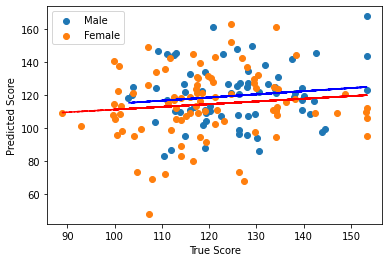

In [9]:
preds = model(X_val).flatten()

correlation = eval_metric(model(X_val).flatten(), y_val).detach().numpy()
pred_val = model(X_val).flatten()
val_loss = torch.sqrt(criterion(pred_val, y_val))

print('Validation Loss: {}; Pearson correlation - {}'.format(val_loss.item(), np.round(correlation, 2)))

x = y_val[gender_val=="M"]
y = preds[gender_val=="M"].detach().numpy()

plt.scatter(x, y, label="Male")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = y_val[gender_val=="F"]
y = preds[gender_val=="F"].detach().numpy()

plt.scatter(x, y, label="Female")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

print(eval_metric(preds[gender_val=="M"], y_val[gender_val=="M"]), eval_metric(preds[gender_val=="F"], y_val[gender_val=="F"]))

plt.title("")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.legend()

Test Loss: 2.6683039967606708; Pearson correlation - 0.10000000149011612
MSE: male; tensor(583.0205, grad_fn=<MseLossBackward0>)
MSE: female; 516.5004


NameError: name 'r2score' is not defined

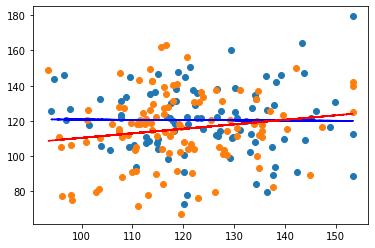

In [14]:
preds = model(X_test).flatten()
test_loss = criterion(preds, y_test)
correlation = eval_metric(preds, y_test).detach().numpy()

print('Test Loss: {}; Pearson correlation - {}'.format(test_loss.item()/len(preds), np.round(correlation, 2)))

x = y_test[gender_test=="M"].numpy()
y = preds[gender_test=="M"].detach().numpy()

print("MSE: male;", criterion(y_test[gender_test=="M"],preds[gender_test=="M"] ))

plt.scatter(x, y, label="Male")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = y_test[gender_test=="F"].numpy()
y = preds[gender_test=="F"].detach().numpy()


print("MSE: female;", ( np.mean((x - y)**2)))

plt.scatter(x, y, label="Female")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

print(r2score(preds[gender_test=="M"], y_test[gender_test=="M"]), r2score(preds[gender_test=="F"], y_test[gender_test=="F"]))

plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.legend()